In [1]:
from glob import glob
import os
import itertools
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import ImageGrid, make_axes_locatable, host_subplot
import matplotlib.ticker as ticker
from matplotlib.collections import Collection, LineCollection
from matplotlib.artist import allow_rasterization
from matplotlib.font_manager import FontProperties
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.dates as md
import matplotlib.ticker as ticker
from metpy.plots import ctables
#from pyPIPS import disdrometer_module as dis
from pyPIPS import pips_io as pipsio
from pyPIPS import timemodule as tm
from pyPIPS.utils import mtokm, getTimeWindow, interp_along_1D
from pyPIPS import plotmodule as pm
from pyPIPS import PIPS as pips
# from pyPIPS import fmcw
from itertools import cycle
import netCDF4 as netcdf
from datetime import datetime, timedelta
import pandas as pd
import xarray as xr
#from skimage.restoration import unwrap_phase
#import skimage.feature as SF
import numpy.ma as ma
from scipy import ndimage, interpolate
import pyart
import cartopy.crs as ccrs
%load_ext autoreload
%autoreload 2
%matplotlib inline

/Users/dawson29/Projects/pyPIPS/pyPIPS/PIPS.py:540: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def calc_empirical_fallspeed(d, correct_rho=False, rho=None):



## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
IOP_name = 'IOP2'
radar_name = 'KGWX'
radar_type= 'NEXRAD'
date = '0330'

gridded_output_dir = f'/Users/dawson29/Projects/PERiLS/obsdata/2022/NEXRAD/GRID3/{IOP_name}/{radar_name}'
if not os.path.exists(gridded_output_dir):
    os.makedirs(gridded_output_dir)
plot_dir = f'/Users/dawson29/Projects/PERiLS/obsdata/2022/NEXRAD/GRID3/{IOP_name}/{radar_name}/plots/'
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

radar_starttimestamp = '20220330225909'
radar_endtimestamp = '20220330225909'

radar_startdatetime = datetime.strptime(radar_starttimestamp, '%Y%m%d%H%M%S')
radar_enddatetime = datetime.strptime(radar_endtimestamp, '%Y%m%d%H%M%S')

radar_start_timestamp = radar_startdatetime.strftime('%Y%m%d%H%M')
radar_end_timestamp = radar_enddatetime.strftime('%Y%m%d%H%M')

cfradial_dir = \
    f'/Users/dawson29/sshfs_mounts/depot/data/Projects/PERiLS/obsdata/2022/NEXRAD/{IOP_name}/{radar_name}'
cfradial_files = sorted(glob(cfradial_dir + '/*V06.nc'))

cfradial_files_to_read = []
for cfradial_file in cfradial_files:
    radar_file_timestamp = os.path.basename(cfradial_file)[4:19]
    radar_file_datetime = datetime.strptime(radar_file_timestamp, '%Y%m%d_%H%M%S')
    if radar_file_datetime >= radar_startdatetime and radar_file_datetime <= radar_enddatetime:
        cfradial_files_to_read.append(cfradial_file)
        print(os.path.basename(cfradial_file))

KGWX20220330_225909_V06.nc


In [3]:
# Read the first file for testing
radarobj = pyart.io.read(cfradial_files_to_read[0])

In [5]:
radarobj.info()

altitude:
	data: <ndarray of type: float64 and shape: (1,)>
	long_name: altitude
	units: meters
	_FillValue: -9999.0
	positive: up
altitude_agl:
	data: <ndarray of type: float64 and shape: (1,)>
	long_name: altitude_above_ground_level
	units: meters
	_FillValue: -9999.0
	positive: up
antenna_transition:
	data: <ndarray of type: int8 and shape: (8280,)>
	long_name: antenna_is_in_transition_between_sweeps
	units: 
	_FillValue: -128
	comment: 1 if antenna is in transition, 0 otherwise
azimuth:
	data: <ndarray of type: float32 and shape: (8280,)>
	long_name: ray_azimuth_angle
	units: degrees
	_FillValue: -9999.0
elevation:
	data: <ndarray of type: float32 and shape: (8280,)>
	long_name: ray_elevation_angle
	units: degrees
	_FillValue: -9999.0
	positive: up
fields:
	REF:
		data: <ndarray of type: float32 and shape: (8280, 1832)>
		long_name: radar_reflectivity
		standard_name: equivalent_reflectivity_factor
		units: dBZ
		sampling_ratio: 1.0
		_FillValue: -128
		grid_mapping: grid_mapping
	

In [6]:
# messing around with smoothing ZDR
# Taken from an old PyART short course notebook here:
# https://notebook.community/openradar/pyart_short_course/2%20Simple%20Py-ART%20Usage%20plotting%20PPI%20data%20on%20a%20map%20and%20add%20a%20new%20field

smooth_zdr = radarobj.fields['ZDR']['data'].copy()
# Now for each of the radials in the volume we want to do an 8-point smooth by convolving the data with a 
# Hanning window..
# rather than write out the code here we are going to use Py-ART's smooth and trim function which also makes sure
# the returned array has the same size as the original array.. 
# Check here: https://github.com/ARM-DOE/pyart/blob/master/pyart/correct/phase_proc.py#L242

for i in range(smooth_zdr.shape[0]):
    smooth_zdr[i,:] = pyart.correct.phase_proc.smooth_and_trim(smooth_zdr[i,:], 8)

# Now that we have add this data as a new field, using the same metadata as the 
# differential_reflectivity field.

radarobj.add_field_like('ZDR', 'ZDR_smooth',  smooth_zdr)

In [7]:
# messing around with smoothing ZDR. Try a 1-D 5-point median filter along rays

footprint = [[1, 1, 1, 1, 1]]

median_zdr = radarobj.fields['ZDR']['data'].copy()

print(median_zdr.shape)

median_zdr = ndimage.median_filter(median_zdr, footprint=footprint)
radarobj.add_field_like('ZDR', 'ZDR_median',  median_zdr)

# for i in range(smooth_zdr.shape[0]):
#     smooth_zdr[i,:] = pyart.correct.phase_proc.smooth_and_trim(smooth_zdr[i,:], 8)

# # Now that we have add this data as a new field, using the same metadata as the 
# # differential_reflectivity field.

# radarobj.add_field_like('ZDR', 'ZDR_smooth',  smooth_zdr)

(8280, 1832)


In [8]:
# Set up grid limits and spacing

xmin = -123000.
xmax = 123000.
dx = 500.
nx = int((xmax - xmin) / dx) + 1

ymin = -123000.
ymax = 123000.
dy = 500.
ny = int((ymax - ymin) / dy) + 1

zmin = 500.
zmax = 4500.
dz = 250.
nz = int((zmax - zmin) / dz) + 1
print(nz)

17


In [9]:
# Test grid first radar file
grid = pyart.map.grid_from_radars(
    (radarobj,),
    grid_shape=(nz, ny, nx),
    grid_limits=((zmin, zmax), (ymin, ymax), (xmin, xmax)),
    fields=['REF', 'ZDR', 'ZDR_smooth', 'ZDR_median', 'RHO'],
    weighting_function='Barnes2',
    map_roi=True)

grid_xr = grid.to_xarray()
print(grid_xr)

<xarray.Dataset>
Dimensions:     (time: 1, z: 17, y: 493, x: 493)
Coordinates:
  * time        (time) object 2022-03-30 22:59:09.667000
  * z           (z) float64 500.0 750.0 1e+03 ... 4e+03 4.25e+03 4.5e+03
    lat         (y, x) float64 32.78 32.78 32.78 32.78 ... 35.0 35.0 35.0 35.0
    lon         (y, x) float64 -89.64 -89.64 -89.63 ... -86.99 -86.98 -86.98
  * y           (y) float64 -1.23e+05 -1.225e+05 ... 1.225e+05 1.23e+05
  * x           (x) float64 -1.23e+05 -1.225e+05 ... 1.225e+05 1.23e+05
Data variables:
    REF         (time, z, y, x) float32 40.39 41.54 42.61 ... 16.33 16.15 15.95
    ZDR         (time, z, y, x) float32 1.135 1.25 1.343 ... 0.3366 0.3306
    ZDR_smooth  (time, z, y, x) float32 1.118 1.233 ... -1.488e+03 -1.439e+03
    ZDR_median  (time, z, y, x) float32 1.134 1.241 ... -1.332e+03 -1.29e+03
    RHO         (time, z, y, x) float32 0.9681 0.967 0.9662 ... 0.9983 0.9984
    ROI         (time, z, y, x) float32 4.58e+03 4.571e+03 ... 4.78e+03


(-89.78, -86.88, 32.68, 35.1)


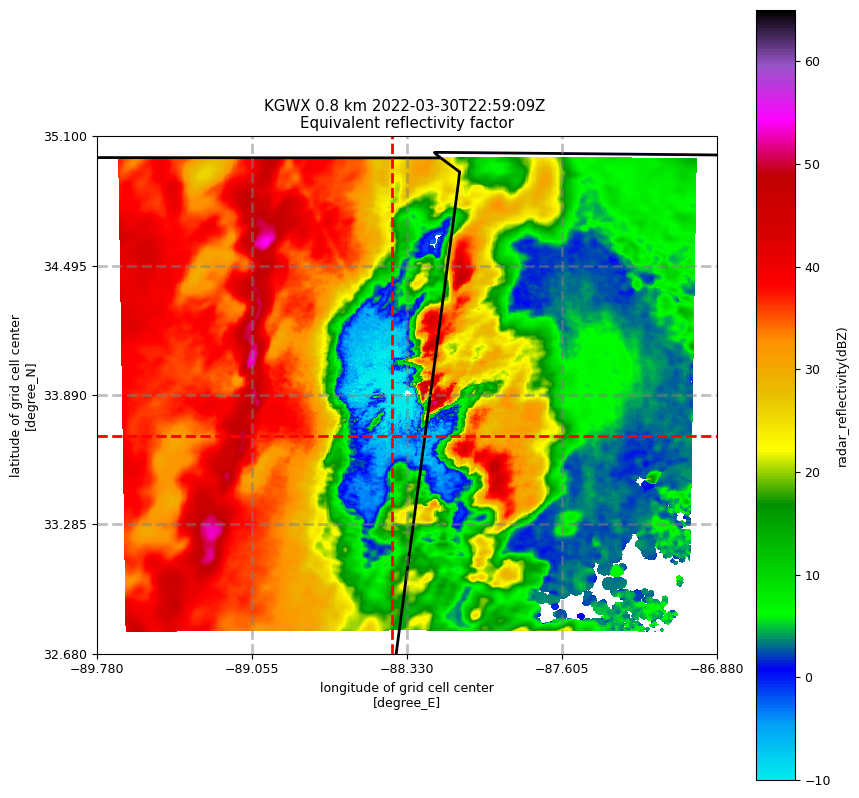

In [10]:
grid_display = pyart.graph.GridMapDisplay(grid)
# Setting projection, figure size, and panel sizes.
projection = ccrs.PlateCarree()

lat = 33.7
lon = -88.4
vmin = -10
vmax = 65

fig_grid, ax_grid = plt.subplots(figsize=(10, 10), subplot_kw={'projection': projection})
grid_display.plot_grid('REF', 1, vmin=vmin, vmax=vmax,
                       ax=ax_grid,
                       projection=projection,
                       cmap='pyart_NWSRef')
grid_display.plot_crosshairs(lon=lon, lat=lat)

# Get the bounds of the axes in the axes coordinate system
bounds = ax_grid.get_extent()
print(bounds)

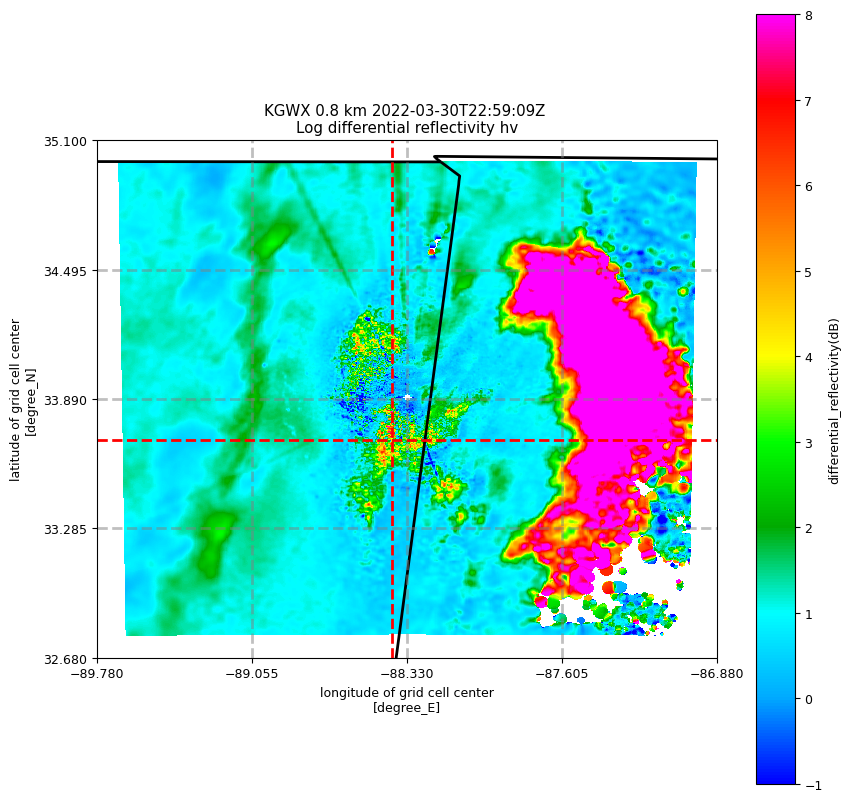

In [11]:
lat = 33.7
lon = -88.4
vmin = -1
vmax = 8

fig_grid, ax_grid = plt.subplots(figsize=(10, 10), subplot_kw={'projection': projection})
grid_display.plot_grid('ZDR', 1, vmin=vmin, vmax=vmax,
                       ax=ax_grid,
                       projection=projection,
                       cmap='pyart_RefDiff')
grid_display.plot_crosshairs(lon=lon, lat=lat)

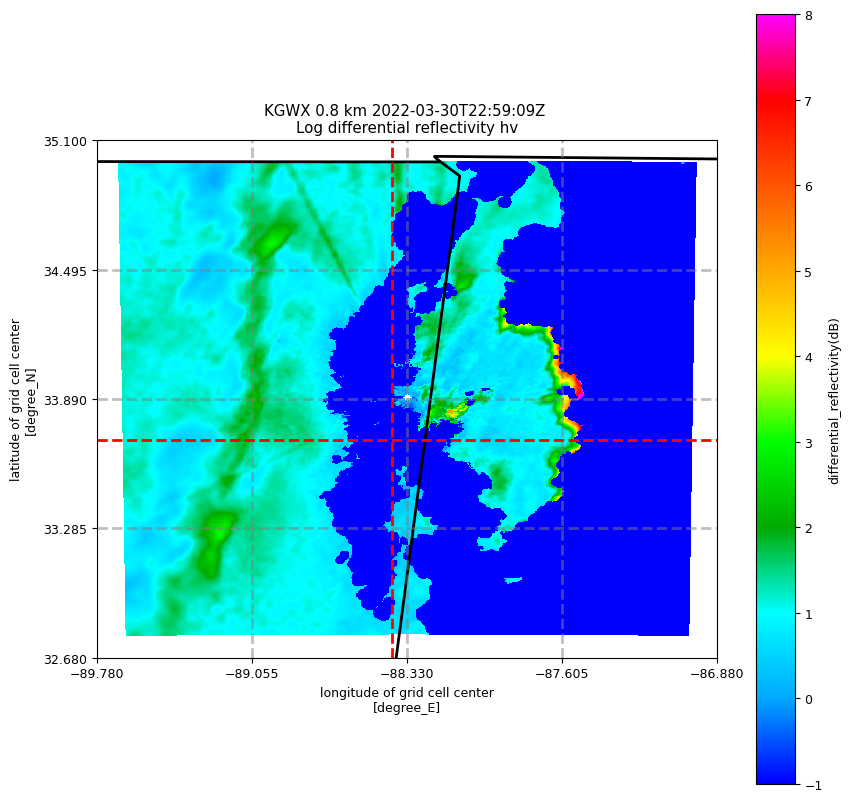

In [12]:
lat = 33.7
lon = -88.4
vmin = -1
vmax = 8

fig_grid, ax_grid = plt.subplots(figsize=(10, 10), subplot_kw={'projection': projection})
grid_display.plot_grid('ZDR_median', 1, vmin=vmin, vmax=vmax,
                       ax=ax_grid,
                       projection=projection,
                       cmap='pyart_RefDiff')
grid_display.plot_crosshairs(lon=lon, lat=lat)

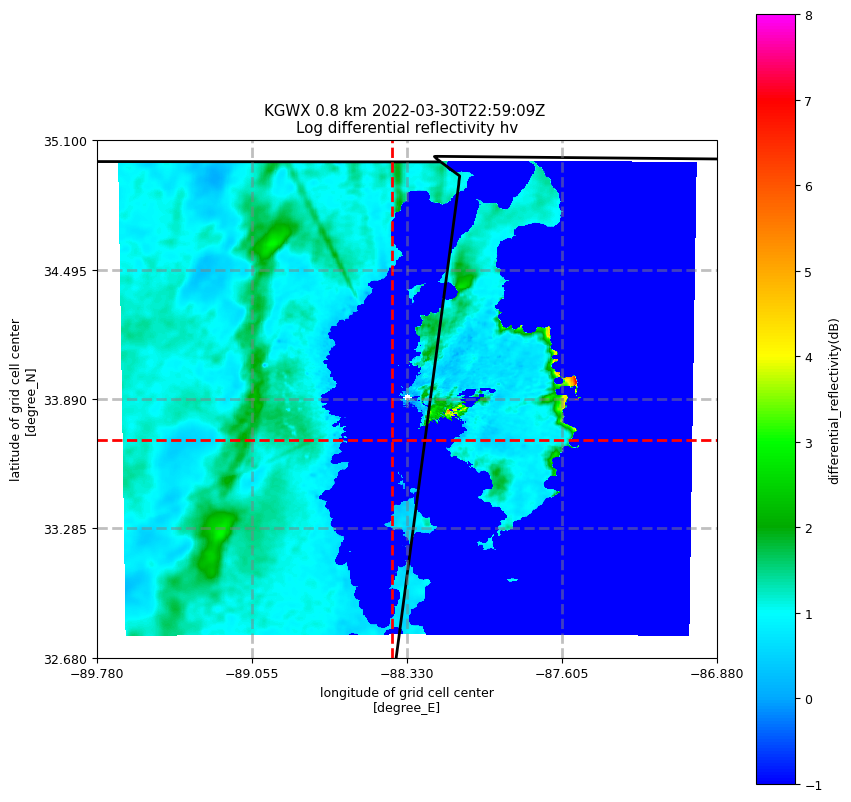

In [13]:
lat = 33.7
lon = -88.4
vmin = -1
vmax = 8

fig_grid, ax_grid = plt.subplots(figsize=(10, 10), subplot_kw={'projection': projection})
grid_display.plot_grid('ZDR_smooth', 1, vmin=vmin, vmax=vmax,
                       ax=ax_grid,
                       projection=projection,
                       cmap='pyart_RefDiff')
grid_display.plot_crosshairs(lon=lon, lat=lat)

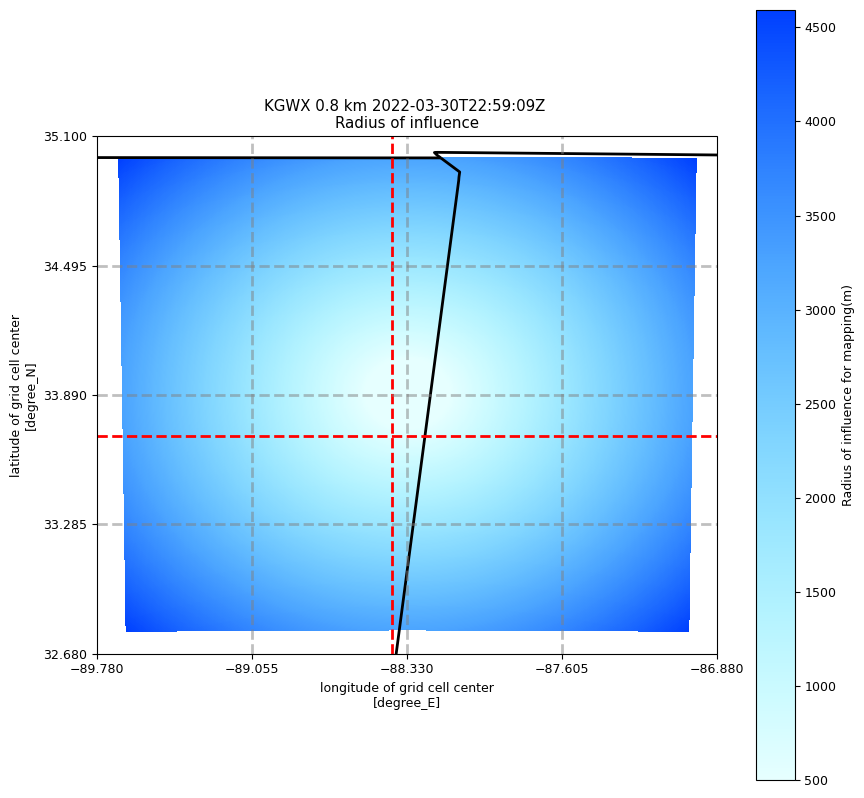

In [14]:
lat = 33.7
lon = -88.4
vmin = -1
vmax = 8

fig_grid, ax_grid = plt.subplots(figsize=(10, 10), subplot_kw={'projection': projection})
grid_display.plot_grid('ROI', 1,
                       ax=ax_grid,
                       projection=projection,
                       cmap='pyart_Bu10')
grid_display.plot_crosshairs(lon=lon, lat=lat)

In [15]:
ppi_display = pyart.graph.RadarMapDisplay(radarobj)

/Users/dawson29/mambaforge/envs/pyPIPS/lib/python3.10/site-packages/pyart/graph/radarmapdisplay.py:523: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  self.ax.plot(line_x, line_y, color, line_style, **kwargs)


(-89.77999999999965, -86.87999999999967, 32.67999999999988, 35.099999999999866)


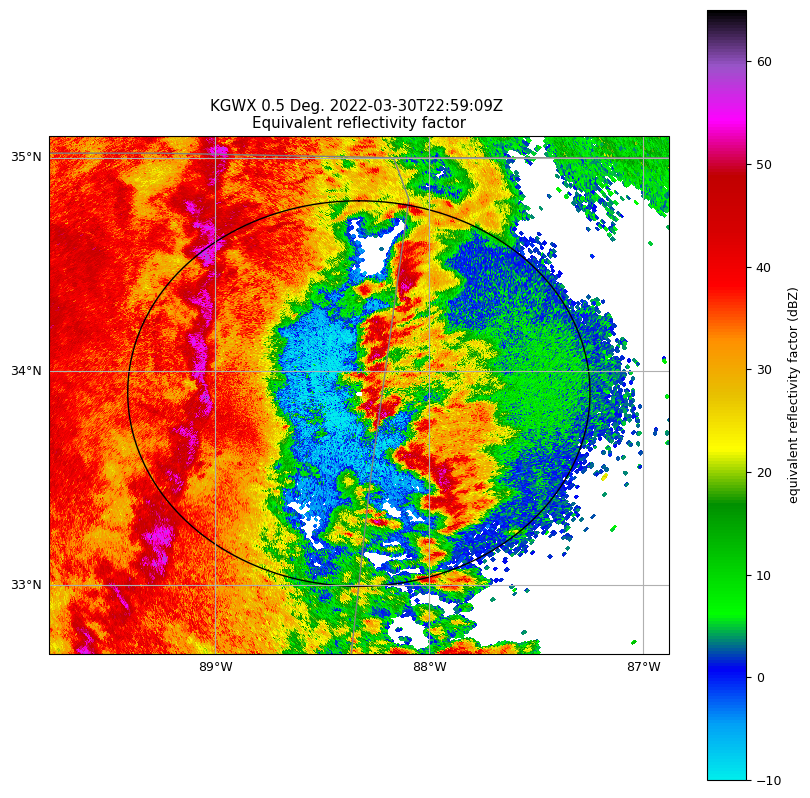

In [16]:
projection = ccrs.PlateCarree()
fig, ax = plt.subplots(figsize=[10, 10], subplot_kw={'projection': projection})
ppi_display.plot_ppi_map(field='REF', sweep=0, vmin=-10, vmax = 65, cmap='pyart_NWSRef', ax=ax)
ppi_display.plot_range_rings([100, 200, 300, 400], lw=1)
ax.set_extent(bounds)
bounds2 = ax.get_extent()
print(bounds2) # should be the same as original bounds

/Users/dawson29/mambaforge/envs/pyPIPS/lib/python3.10/site-packages/pyart/graph/radarmapdisplay.py:523: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  self.ax.plot(line_x, line_y, color, line_style, **kwargs)


(-89.77999999999965, -86.87999999999967, 32.67999999999988, 35.099999999999866)


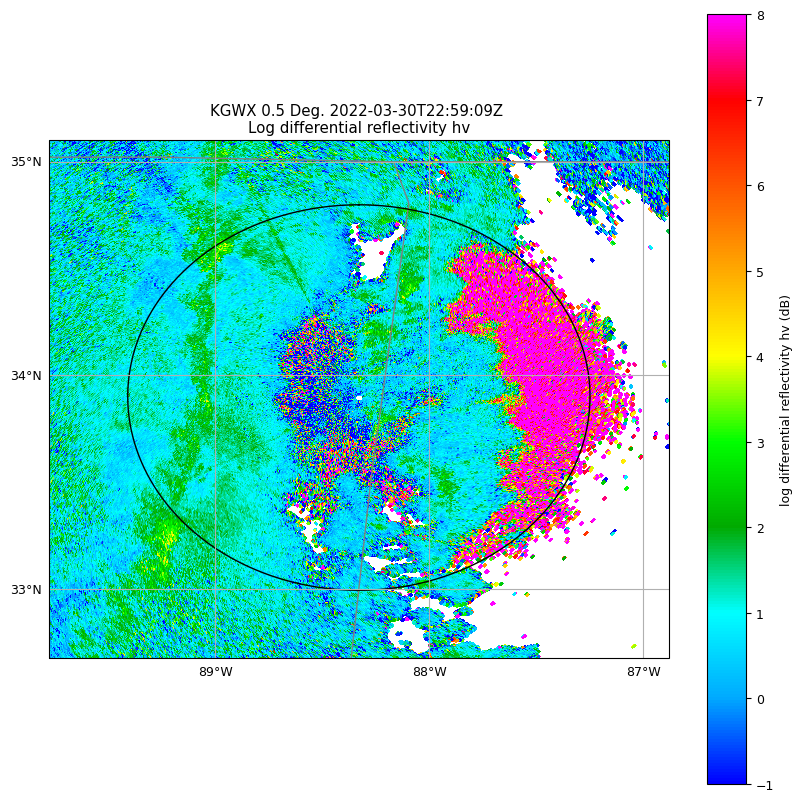

In [17]:
projection = ccrs.PlateCarree()
fig, ax = plt.subplots(figsize=[10, 10], subplot_kw={'projection': projection})
ppi_display.plot_ppi_map(field='ZDR', sweep=0, vmin=-1, vmax = 8, cmap='pyart_RefDiff', ax=ax)
ppi_display.plot_range_rings([100, 200, 300, 400], lw=1)
ax.set_extent(bounds)
bounds2 = ax.get_extent()
print(bounds2) # should be the same as original bounds

/Users/dawson29/mambaforge/envs/pyPIPS/lib/python3.10/site-packages/pyart/graph/radarmapdisplay.py:523: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  self.ax.plot(line_x, line_y, color, line_style, **kwargs)


(-89.77999999999965, -86.87999999999967, 32.67999999999988, 35.099999999999866)


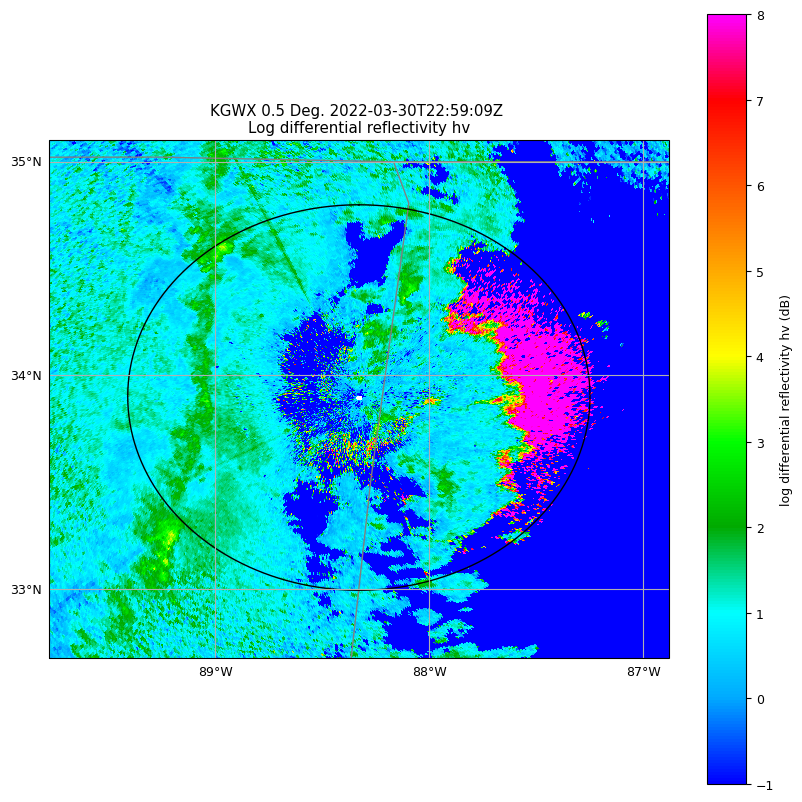

In [18]:
projection = ccrs.PlateCarree()
fig, ax = plt.subplots(figsize=[10, 10], subplot_kw={'projection': projection})
ppi_display.plot_ppi_map(field='ZDR_smooth', sweep=0, vmin=-1, vmax = 8, cmap='pyart_RefDiff', ax=ax)
ppi_display.plot_range_rings([100, 200, 300, 400], lw=1)
ax.set_extent(bounds)
bounds2 = ax.get_extent()
print(bounds2) # should be the same as original bounds

/Users/dawson29/mambaforge/envs/pyPIPS/lib/python3.10/site-packages/pyart/graph/radarmapdisplay.py:523: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  self.ax.plot(line_x, line_y, color, line_style, **kwargs)


(-89.77999999999965, -86.87999999999967, 32.67999999999988, 35.099999999999866)


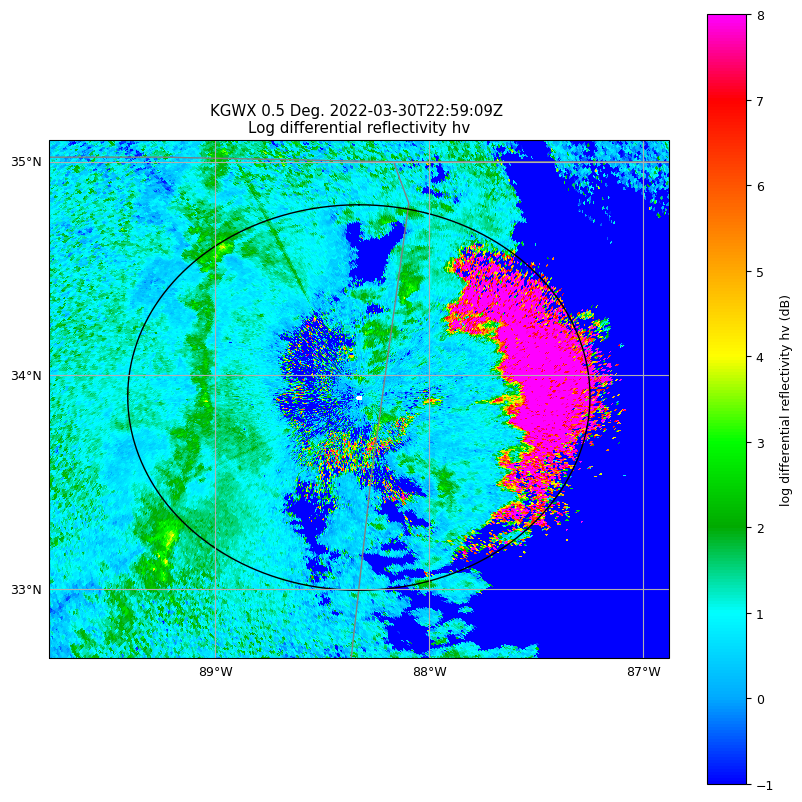

In [19]:
projection = ccrs.PlateCarree()
fig, ax = plt.subplots(figsize=[10, 10], subplot_kw={'projection': projection})
ppi_display.plot_ppi_map(field='ZDR_median', sweep=0, vmin=-1, vmax = 8, cmap='pyart_RefDiff', ax=ax)
ppi_display.plot_range_rings([100, 200, 300, 400], lw=1)
ax.set_extent(bounds)
bounds2 = ax.get_extent()
print(bounds2) # should be the same as original bounds

In [ ]:
# Create gridded radar objects and dump to disk
for i, f in enumerate(level2_files_to_read):
    print("On file {:d} of {:d} ({:.2f}%)".format(i+1, len(level2_files), (i+1)/len(level2_files)*100.))
    print("Reading {}".format(os.path.basename(f)))
    radar = pyart.io.read_nexrad_archive(f)
    output_file = os.path.basename(f)[:-5]+"_gridded.nc"
    output_path = os.path.join(gridded_output_dir, output_file)
    
    print("Mapping to grid!")
    grid = pyart.map.grid_from_radars(
        (radar,),
        grid_shape=(nz, ny, nx),
        grid_limits=((zmin, zmax), (ymin, ymax), (xmin, xmax)),
        fields=['differential_reflectivity', 'reflectivity', 'cross_correlation_ratio'],
        weighting_function='Barnes2')
    print("Writing {}".format(output_file))
    pyart.io.write_grid(output_path, grid, arm_time_variables=True, arm_alt_lat_lon_variables=True, 
                        write_point_x_y_z=True, write_point_lon_lat_alt=True)
